# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.832988,False,0.497823
1,-2.569926,False,-1.202289
2,-0.504787,False,-1.773538
3,-0.046876,False,0.176519
4,-0.216126,False,1.335532
...,...,...,...
995,-0.245720,True,5.981728
996,0.017892,False,-0.845023
997,-1.581344,False,-1.525959
998,-0.508796,False,-0.644371


<AxesSubplot:xlabel='v0'>

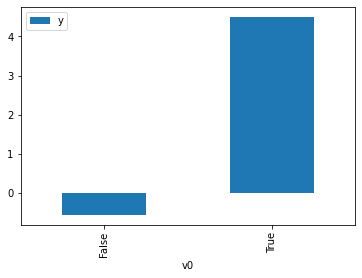

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

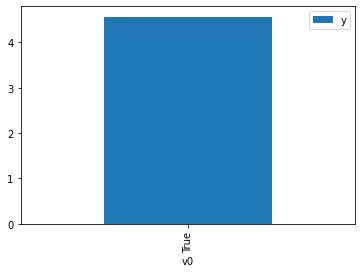

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.179996,False,0.809273,0.609444,1.640839
1,-1.576401,False,-0.525282,0.976408,1.024162
2,0.675643,False,-0.066530,0.173131,5.775964
3,-0.866217,False,-1.577441,0.886537,1.127984
4,-0.851276,False,-1.226849,0.882961,1.132553
...,...,...,...,...,...
995,-2.878935,False,-0.909766,0.998866,1.001136
996,-1.581344,False,-1.525959,0.976674,1.023883
997,-1.458289,False,-1.610629,0.969103,1.031882
998,-0.944229,False,-1.983212,0.903695,1.106567


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.779254,True,4.972477,0.135673,7.370674
1,-1.372015,True,3.611434,0.037573,26.615122
2,-0.772927,True,4.460582,0.137424,7.276762
3,-1.467343,True,3.166262,0.030267,33.039236
4,-1.372015,True,3.611434,0.037573,26.615122
...,...,...,...,...,...
995,-1.467343,True,3.166262,0.030267,33.039236
996,-1.472969,True,3.093660,0.029882,33.465210
997,-0.628181,True,4.823224,0.182863,5.468568
998,-1.472969,True,3.093660,0.029882,33.465210


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              3750.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:07:34   Log-Likelihood:                         -1409.8
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2833.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6169      0.024     25.530      0.000       0.570       0.664
x2             4.9312      0.061     80.346      0.000       4.811       5.052
==============================================================================
Omnibus:                        1.507   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.538
Skew:                           0.056   Prob(JB):                        0.464
Kurtosis:                       2.844   Cond. No.                         2.55
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""